In [22]:
# LSTM长短期记忆网络 Long Short-Term Memory

In [23]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.6.4
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.6.4
tensorflow.keras 2.6.0


In [24]:
imdb = keras.datasets.imdb
vocab_size = 10000
index_from = 3
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=vocab_size, index_from=index_from)
word_index = imdb.get_word_index()
print(len(word_index))
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2
word_index['<END>'] = 3

88584


In [25]:
reverse_word_index = dict(
    [(value, key) for key, value in word_index.items()])


def decode_review(text_ids):
    return ' '.join(
        [reverse_word_index.get(word_id, "<UNK>") for word_id in text_ids])

decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [26]:
max_length=500
train_data=keras.preprocessing.sequence.pad_sequences(
    train_data,
    value=word_index['<PAD>'],
    padding='post',
    maxlen=max_length)
print(train_data[1])
test_data=keras.preprocessing.sequence.pad_sequences(
    test_data,
    value=word_index['<PAD>'],
    padding='post',
    maxlen=max_length)
print(test_data[1])

[   1  194 1153  194 8255   78  228    5    6 1463 4369 5012  134   26
    4  715    8  118 1634   14  394   20   13  119  954  189  102    5
  207  110 3103   21   14   69  188    8   30   23    7    4  249  126
   93    4  114    9 2300 1523    5  647    4  116    9   35 8163    4
  229    9  340 1322    4  118    9    4  130 4901   19    4 1002    5
   89   29  952   46   37    4  455    9   45   43   38 1543 1905  398
    4 1649   26 6853    5  163   11 3215    2    4 1153    9  194  775
    7 8255    2  349 2637  148  605    2 8003   15  123  125   68    2
 6853   15  349  165 4362   98    5    4  228    9   43    2 1157   15
  299  120    5  120  174   11  220  175  136   50    9 4373  228 8255
    5    2  656  245 2350    5    4 9837  131  152  491   18    2   32
 7464 1212   14    9    6  371   78   22  625   64 1382    9    8  168
  145   23    4 1690   15   16    4 1355    5   28    6   52  154  462
   33   89   78  285   16  145   95    0    0    0    0    0    0    0
    0 

In [44]:
embedding_dim = 16
batch_size = 512
# 单向单层LSTM
single_lstm_model=keras.models.Sequential([
    keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    # return_sequences=True返回所有输出序列，False只返回最后一个输出
    # return_sequences不再返回前面的输出结果，只保留rnn所有输出结果的最后一个
    keras.layers.LSTM(units=64, # 输出空间的维度 隐藏层神经元数
                           return_sequences=False),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])
single_lstm_model.summary()
single_lstm_model.compile(optimizer = 'adam',
                         loss = 'binary_crossentropy',
                         metrics = ['accuracy'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 184,961
Trainable params: 184,961
Non-trainable params: 0
_________________________________________________________________


In [28]:
single_lstm_model.variables

[<tf.Variable 'embedding_3/embeddings:0' shape=(10000, 16) dtype=float32, numpy=
 array([[-0.01963127, -0.0386981 , -0.02639972, ...,  0.01143086,
          0.01224239, -0.01560464],
        [-0.03030646,  0.02621123, -0.03645406, ...,  0.04597645,
          0.02624568, -0.03431032],
        [ 0.0078975 ,  0.01986868, -0.03808346, ..., -0.02478005,
         -0.01399853,  0.01561281],
        ...,
        [-0.0094308 ,  0.04926031,  0.0014212 , ...,  0.01103013,
         -0.04660827, -0.00375028],
        [-0.0290761 ,  0.04469777, -0.00069028, ..., -0.03284012,
          0.04494179, -0.01160268],
        [ 0.03922877,  0.04801658, -0.03648436, ...,  0.00480918,
         -0.04519875, -0.02301559]], dtype=float32)>,
 <tf.Variable 'lstm_4/lstm_cell_10/kernel:0' shape=(16, 256) dtype=float32, numpy=
 array([[ 5.64734787e-02,  8.67235959e-02,  1.23131663e-01, ...,
         -5.17973974e-02,  1.16894186e-01,  2.78687179e-02],
        [ 9.83753949e-02, -8.08163211e-02,  2.07770318e-02, ...,
  

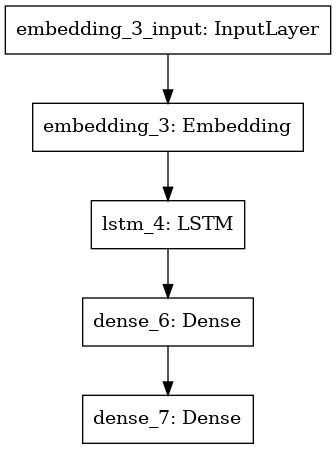

In [29]:
from tensorflow.keras.utils import plot_model
plot_model(single_lstm_model)

In [30]:
history_single_lstm = single_lstm_model.fit(
    train_data, train_labels,
    epochs = 30,
    batch_size = batch_size,
    validation_split = 0.2)

Epoch 1/30
40/40 [==============================] - 4s 54ms/step - loss: 0.6931 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5028
Epoch 2/30
40/40 [==============================] - 2s 45ms/step - loss: 0.6922 - accuracy: 0.5094 - val_loss: 0.6925 - val_accuracy: 0.5044
Epoch 3/30
40/40 [==============================] - 2s 44ms/step - loss: 0.6874 - accuracy: 0.5160 - val_loss: 0.6864 - val_accuracy: 0.5244
Epoch 4/30
40/40 [==============================] - 2s 44ms/step - loss: 0.6896 - accuracy: 0.5350 - val_loss: 0.6895 - val_accuracy: 0.5192
Epoch 5/30
40/40 [==============================] - 2s 45ms/step - loss: 0.6828 - accuracy: 0.5296 - val_loss: 0.6895 - val_accuracy: 0.5136
Epoch 6/30
40/40 [==============================] - 2s 44ms/step - loss: 0.6706 - accuracy: 0.5340 - val_loss: 0.6907 - val_accuracy: 0.5296
Epoch 7/30
40/40 [==============================] - 2s 44ms/step - loss: 0.6673 - accuracy: 0.5360 - val_loss: 0.6827 - val_accuracy: 0.5242
Epoch 8/30
40

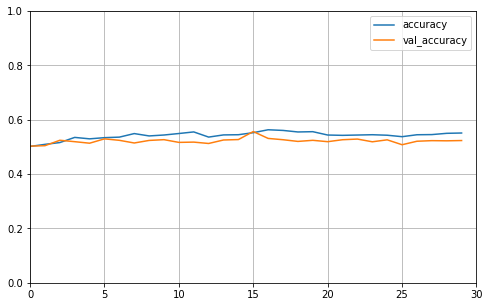

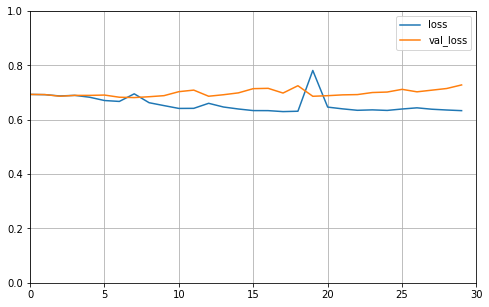

In [31]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
plot_learning_curves(history_single_lstm, 'accuracy', 30, 0, 1)
plot_learning_curves(history_single_lstm, 'loss', 30, 0, 1)

In [32]:
print(single_lstm_model.evaluate(
    test_data, test_labels,
    batch_size = batch_size,
    verbose = 0))

[0.7155417799949646, 0.5220000147819519]


In [33]:
embedding_dim = 16
batch_size = 512
# 双向双层LSTM
model=keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length),
    keras.layers.Bidirectional(
        keras.layers.LSTM(units=64,return_sequences=True)), # 得到max_length个输出(None, 500, 128)
    keras.layers.Bidirectional(
        keras.layers.LSTM(units=64,return_sequences=False)),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')])
model.summary()
model.compile(optimizer = 'adam',
             #  当只有两个标签类别（假定为0和1）时，使用二值交叉熵损失
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 500, 128)          41472     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 308,609
Trainable params: 308,609
Non-trainable params: 0
_________________________________________________________________


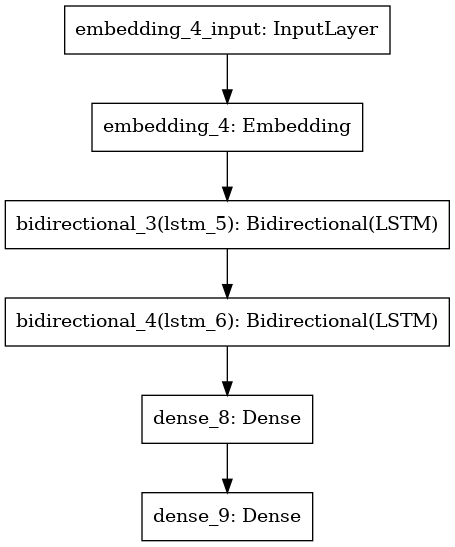

In [34]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [43]:
print(model.variables)

[<tf.Variable 'embedding_4/embeddings:0' shape=(10000, 16) dtype=float32, numpy=
array([[-0.01269596,  0.03791134,  0.05454006, ...,  0.01870261,
         0.03896619, -0.00877594],
       [ 0.05322531, -0.01885133, -0.02154497, ...,  0.04318129,
        -0.00589278,  0.00901169],
       [ 0.04373356, -0.01596777,  0.02729564, ...,  0.01812418,
         0.01335847,  0.00905905],
       ...,
       [-0.07902026,  0.0187382 ,  0.0246463 , ..., -0.06159668,
        -0.01421051, -0.0664148 ],
       [ 0.10921513, -0.08643861,  0.07801969, ...,  0.13200241,
         0.1246801 ,  0.15334801],
       [-0.06597113,  0.10522924, -0.05780261, ..., -0.04056071,
        -0.00757684, -0.00091773]], dtype=float32)>, <tf.Variable 'bidirectional_3/forward_lstm_5/lstm_cell_12/kernel:0' shape=(16, 256) dtype=float32, numpy=
array([[-0.16346808, -0.07952734,  0.04328201, ...,  0.04224866,
        -0.09672178,  0.16368873],
       [ 0.09428039,  0.08742876,  0.01649653, ...,  0.05754602,
         0.1009701

In [36]:
history = model.fit(
    train_data, train_labels,
    epochs = 30,
    batch_size = batch_size,
    validation_split = 0.2)

Epoch 1/30
40/40 [==============================] - 14s 246ms/step - loss: 0.6715 - accuracy: 0.5612 - val_loss: 0.5408 - val_accuracy: 0.7340
Epoch 2/30
40/40 [==============================] - 9s 215ms/step - loss: 0.5160 - accuracy: 0.7571 - val_loss: 0.4419 - val_accuracy: 0.8006
Epoch 3/30
40/40 [==============================] - 9s 218ms/step - loss: 0.3405 - accuracy: 0.8619 - val_loss: 0.3789 - val_accuracy: 0.8354
Epoch 4/30
40/40 [==============================] - 9s 215ms/step - loss: 0.2679 - accuracy: 0.9020 - val_loss: 0.4313 - val_accuracy: 0.8316
Epoch 5/30
40/40 [==============================] - 9s 215ms/step - loss: 0.2191 - accuracy: 0.9239 - val_loss: 0.3601 - val_accuracy: 0.8634
Epoch 6/30
40/40 [==============================] - 9s 214ms/step - loss: 0.1740 - accuracy: 0.9424 - val_loss: 0.3611 - val_accuracy: 0.8684
Epoch 7/30
40/40 [==============================] - 9s 217ms/step - loss: 0.1390 - accuracy: 0.9578 - val_loss: 0.4062 - val_accuracy: 0.8676
Epoch

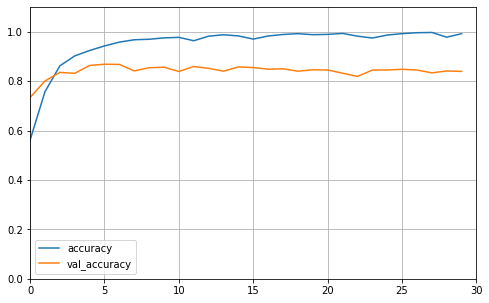

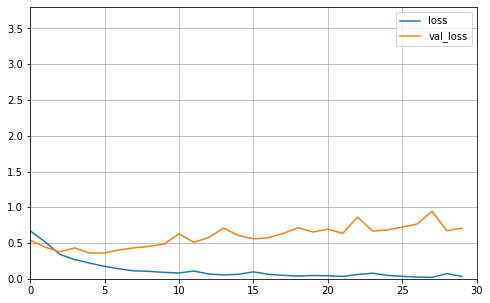

In [37]:
model.evaluate(test_data, test_labels, batch_size = batch_size, verbose = 0)
plot_learning_curves(history, 'accuracy', 30, 0, 1.1)
plot_learning_curves(history, 'loss', 30, 0, 3.8)

In [38]:
embedding_dim = 16
batch_size = 512
# 过拟合改为双向单层LSTM
bi_rnn_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length),
    keras.layers.Bidirectional(
        keras.layers.LSTM(units = 32, return_sequences = False)),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid'),])
bi_rnn_model.summary()
bi_rnn_model.compile(optimizer = 'adam',
                     loss = 'binary_crossentropy',
                     metrics = ['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 174,657
Trainable params: 174,657
Non-trainable params: 0
_________________________________________________________________


In [39]:
bi_rnn_model.variables

[<tf.Variable 'embedding_5/embeddings:0' shape=(10000, 16) dtype=float32, numpy=
 array([[ 0.04937219, -0.02275021,  0.03298613, ..., -0.01618726,
         -0.00073923, -0.03208985],
        [-0.02016455, -0.01341927, -0.03684279, ...,  0.04709429,
          0.02584875, -0.00093563],
        [ 0.04005081, -0.0497087 , -0.04675775, ..., -0.04216609,
          0.02887588,  0.04952464],
        ...,
        [-0.00914017, -0.00809712, -0.0248531 , ...,  0.02743964,
          0.02817914,  0.00636942],
        [ 0.01869914, -0.03849734, -0.04877416, ..., -0.0436019 ,
         -0.03457985, -0.02055163],
        [ 0.04735601, -0.02311518,  0.03126952, ..., -0.03402257,
         -0.03828132, -0.00116068]], dtype=float32)>,
 <tf.Variable 'bidirectional_5/forward_lstm_7/lstm_cell_18/kernel:0' shape=(16, 128) dtype=float32, numpy=
 array([[-0.0837062 , -0.02883689, -0.18286164, ..., -0.1835002 ,
          0.04314032,  0.09578088],
        [ 0.20400944,  0.14801997,  0.08251157, ...,  0.15336892,
 

In [40]:
history = bi_rnn_model.fit(
    train_data, train_labels,
    epochs = 30,
    batch_size = batch_size,
    validation_split = 0.2)

Epoch 1/30
40/40 [==============================] - 7s 96ms/step - loss: 0.6827 - accuracy: 0.5714 - val_loss: 0.6279 - val_accuracy: 0.6848
Epoch 2/30
40/40 [==============================] - 3s 82ms/step - loss: 0.4960 - accuracy: 0.7764 - val_loss: 0.4040 - val_accuracy: 0.8298
Epoch 3/30
40/40 [==============================] - 3s 82ms/step - loss: 0.3075 - accuracy: 0.8779 - val_loss: 0.3060 - val_accuracy: 0.8832
Epoch 4/30
40/40 [==============================] - 3s 80ms/step - loss: 0.2130 - accuracy: 0.9217 - val_loss: 0.2988 - val_accuracy: 0.8848
Epoch 5/30
40/40 [==============================] - 3s 81ms/step - loss: 0.1607 - accuracy: 0.9457 - val_loss: 0.3114 - val_accuracy: 0.8894
Epoch 6/30
40/40 [==============================] - 3s 82ms/step - loss: 0.1332 - accuracy: 0.9571 - val_loss: 0.3216 - val_accuracy: 0.8834
Epoch 7/30
40/40 [==============================] - 3s 79ms/step - loss: 0.1112 - accuracy: 0.9650 - val_loss: 0.3529 - val_accuracy: 0.8824
Epoch 8/30
40

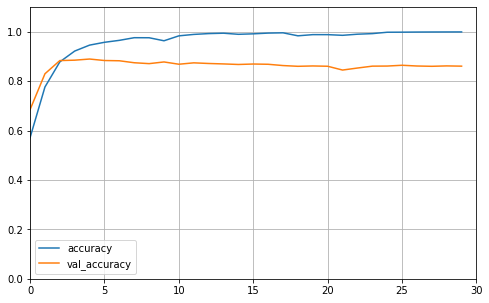

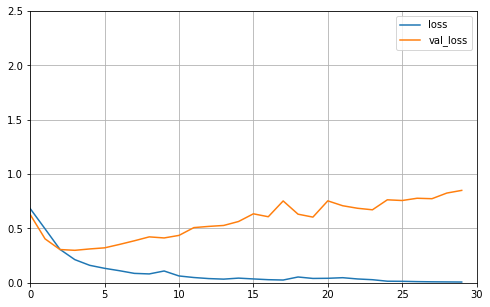

In [41]:
plot_learning_curves(history, 'accuracy', 30, 0, 1.1)
plot_learning_curves(history, 'loss', 30, 0, 2.5)

In [42]:
bi_rnn_model.evaluate(test_data, test_labels, batch_size = batch_size, verbose = 0)


[1.0044039487838745, 0.8356800079345703]